In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

df = pd.read_csv(r'./train.csv')

In [3]:
df=df.drop(['id'],axis=1)
df.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
1,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
2,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
3,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
4,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [13]:
#生成样本集
y = df['target']
x =df.drop(['target'],axis=1)
#将样本集分成训练集和验证集
X_train,test_x,y_train,test_y = train_test_split(x,y,test_size=0.5,random_state=8)
#再将训练集拆成两个部分（GBDT/RF,LR）
X_train,X_train_lr,y_train,y_train_lr = train_test_split(X_train,y_train,test_size=0.5,random_state=8)

In [14]:
#基于随机森林的监督变换
n_estimators=10  #设置分类器数为10
rf = RandomForestClassifier(max_depth=3,
                            n_estimators=n_estimators)
rf.fit(X_train,y_train)
#得到OneHot编码
rf_enc = OneHotEncoder(categories='auto')
rf_enc.fit(rf.apply(X_train))
#使用OneHot编码作为特征训练LR
rf_lm = LogisticRegression(solver='lbfgs',max_iter=1000)
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)),y_train_lr)

#使用RF_LR进行预测，返回预测所有样本标签为1（结冰）的概率数组
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(test_x)))[:,1]
fpr_rf_lm,tpr_rf_lm,_ = roc_curve(test_y,y_pred_rf_lm)

#基于GBDT监督变换
grd = GradientBoostingClassifier(n_estimators=n_estimators)
grd.fit(X_train,y_train)
#OneHot编码
grd_enc = OneHotEncoder(categories='auto')
grd_enc.fit(grd.apply(X_train)[:, :, 0])
# 使用OneHot编码作为特征，训练LR
grd_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)
# 使用GBDT_LR进行预测
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(test_x)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(test_y, y_pred_grd_lm)
# 直接使用GBDT进行预测
y_pred_grd = grd.predict_proba(test_x)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(test_y, y_pred_grd)

# 直接使用RF进行预测
y_pred_rf = rf.predict_proba(test_x)[:, 1]
fpr_rf, tpr_rf, thresholds_skl = roc_curve(test_y, y_pred_rf)

# 直接使用LR进行预测
LR = LogisticRegression(n_jobs=4, C=0.1, penalty='l2')
LR.fit(X_train, y_train)
y_pred = LR.predict_proba(test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(test_y, y_pred)

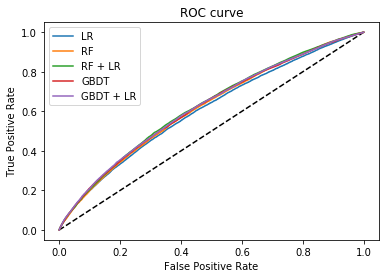

In [15]:
#绘制ROC曲线
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBDT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBDT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

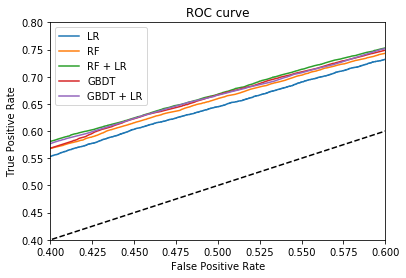

In [19]:
# 将左上角放大显示
plt.figure(2)
plt.xlim(0.4,0.6)
plt.ylim(0.4,0.8)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBDT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBDT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

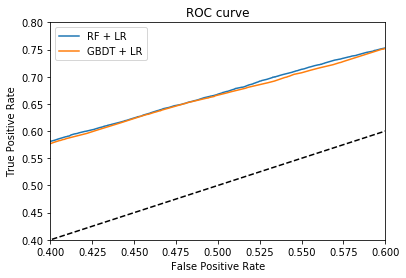

In [21]:
# 将左上角放大显示
plt.figure(2)
plt.xlim(0.4,0.6)
plt.ylim(0.4,0.8)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBDT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#使用RF+LR和GBDT+LR的效果近似